In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import random

In [2]:
data_path = '../../data/unigram_kl/'

In [3]:
data_path2 = '../../data/'

In [4]:
[i for i in os.listdir(data_path) if 'fix' in i]

['bishoujo_senshi_sailor_moon_processed3_fixed.tsv',
 'haikyuu_processed3_fixed.tsv',
 'hamilton_miranda_processed3_fixed.tsv',
 'kuroko_no_basuke_processed3_fixed.tsv',
 'les_miserables_all_media_types_processed3_fixed.tsv',
 'original_work_processed3_fixed.tsv',
 'shakespare_william_works_processed3_fixed.tsv',
 'the_walking_dead_&_related_fandoms_processed3_fixed.tsv']

In [22]:
fandom_list = ['bishoujo_senshi_sailor_moon',
'haikyuu',
'hamilton_miranda',
'kuroko_no_basuke',
'les_miserables_all_media_types',
'the_walking_dead_&_related_fandoms']

In [5]:
def bootstrap_resample(li):
    if len(li) > 0:
        ave_original = np.average(li)
        aves = []
        for i in range(1000):
            sample = []
            for i in range(len(li)):
                sample.append(random.choice(li))
            aves.append(np.average(sample))
        tail = sorted(aves)[24]
        head = sorted(aves)[975]
        return (ave_original, tail, head)

In [6]:
def create_normed_dfs(df):
    df = df.drop([0,1])
    
#     # Normalize effects of authors by turning kudos into z-score corresponding to works from this author
#     author_list = df.Author.drop_duplicates().tolist()
#     combined = []
#     for author in author_list:
#         df_a = df[df.Author == author]
#         if len(df_a) > 1:
#             df_a = df_a[['Author', 'Kudos', 'KL', 'Hits']]
#             df_a['Kudos_zscore'] = (df_a['Kudos'] - df_a['Kudos'].mean())/df_a['Kudos'].std(ddof=0)
#             combined.append(df_a)        
#     df = pd.concat(combined)
#     df = df[df.Kudos_zscore != 0]


    # Normalize by using hits/kudos
        
#     df = df[df.Hits != 0]
#     df = df[df.Kudos != 0]
    
#     df['Kudos'] = np.log(df['Kudos'])
#     df['Hits'] = np.log(df['Hits'])
    
#     df['Kudos/Hits'] = df['Kudos'].astype(float)/df['Hits'].astype(float)
    
    # Normalize by log scale
    df = df[df.Kudos != 0]
    df['Kudos'] = np.log(df['Kudos'])
    df = df[df.Hits != 0]
    df['Hits'] = np.log(df['Hits'])

    # filter 0s
#     df = df.fillna(0)

    # turn other fields into z scores
    df['KL'] = df['KL'].astype(float)
    df['KL'] = (df['KL'] - df['KL'].mean())/df['KL'].std(ddof=0)
#     df['Kudos/Hits'] = (df['Kudos/Hits'] - df['Kudos/Hits'].mean())/df['Kudos/Hits'].std(ddof=0)

    #focus on part of the KL range
    df = df[df['KL'] <= 4]
    df = df[df['KL'] >= -2]
    return df

In [7]:
def create_dict(fandom_list, field, binsize):
    kk_dict_all = {}
    
    for f in fandom_list:
        df = pd.read_csv(os.path.join(data_path,f+'_processed3_fixed.tsv'), sep = '\t')
        df = create_normed_dfs(df)
        
        # Make bins
        df.KL = df.KL.astype(float)
        min_kl = int(min(df.KL.tolist())) -1
        max_kl = int(max(df.KL.tolist())) +1
        kk_dict = {}
        for i in np.arange(min_kl, max_kl, binsize):
            df_s = df[(df.KL >= i) & (df.KL < i+binsize)]
#             kk_dict[i] = np.average(df_s.Kudos_zscore.tolist())
            if len(df_s) > 0:
                kk_dict[i] = bootstrap_resample(df_s[field].tolist())
        kk_dict_all[f] = kk_dict
    return kk_dict_all

In [10]:
dic = create_dict(fandom_list, 'Kudos', 0.5)

In [117]:
def plot_scatter(fandom_list, dic):
    fig, axs = plt.subplots(2,3, figsize=(25, 8))
    axs = axs.ravel()
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.rcParams.update({'axes.titlesize': 'large'})
    
    for i in range(0, len(fandom_list)):
        x = sorted(dic[fandom_list[i]].keys())
        y = [dic[fandom_list[i]][j][0] for j in x]

#     Make error bars
        lower_error = [dic[fandom_list[i]][j][0]-dic[fandom_list[i]][j][1] for j in x]
        upper_error = [dic[fandom_list[i]][j][2]-dic[fandom_list[i]][j][0] for j in x]
        asymmetric_error = [lower_error, upper_error]

        axs[i].errorbar(x, y, yerr=asymmetric_error,fmt='o')
        axs[i].plot(x, y, 'o-')
        axs[i].set_title(fandom_list[i], fontsize = 20)
        axs[i].set_xlim([min(x) -1, max(x) + 1])
        axs[i].set_ylim([min(y) -0.2, max(y) + 0.2])
        for tick in axs[i].xaxis.get_major_ticks():
            tick.label.set_fontsize(16) 
        for tick in axs[i].yaxis.get_major_ticks():
            tick.label.set_fontsize(16)
        
        # ax.set_yscale('log')

    fig.text(0.5, 0.06, 'KLs', ha='center', va='center', fontsize=25)
    fig.text(0.08, 0.5, 'Log of kudos', ha='center', va='center', rotation='vertical',fontsize=25)
    
    plt.savefig('kl_kudos.png', format = 'png')


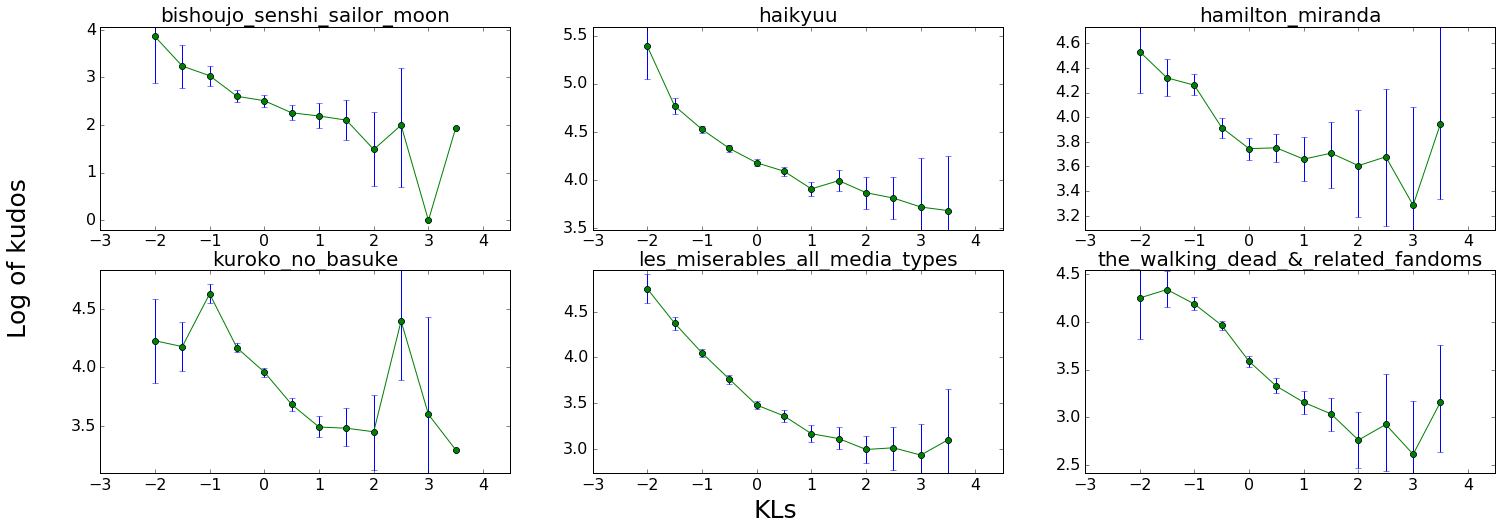

In [118]:
plot_scatter(fandom_list, dic)

In [36]:
# kl_kudos_scatter(fandom_list, 0.1)